In [12]:
# 라이브러리 호출
import json
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [13]:
dataSetPath = '/content/drive/MyDrive/oiltank_dataset/oiltank_dataset/'
trainDataImgPath = dataSetPath + 'train_images'
trainDataLabelPath = dataSetPath + 'train_labels'

In [14]:
for fname in os.listdir(trainDataImgPath):
    if fname[-3:] != 'png':
        os.remove(trainDataImgPath + f'/{fname}')

In [15]:
# json to csv 함수 정의
def json2csv(fname):
    with open(fname, 'r', encoding='utf-8') as inputFile:
        data = json.load(inputFile)


In [16]:
for i in os.listdir(trainDataLabelPath):
    with open(trainDataLabelPath + f'/{i}') as f:
        jsonData = json.load(f)
        data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
        for j, property in enumerate(jsonData['features']):
            data.loc[j] = list(map(float, property['properties']['object_imcoords'].split(sep=',')))

        data.to_csv(trainDataLabelPath + '/' + i.split(sep=".")[0]+ '.csv', index=False)

JSONDecodeError: ignored

In [18]:
for i in os.listdir(trainDataLabelPath):
    if i[-3:] != 'csv':
        os.remove(trainDataLabelPath + f'/{i}')

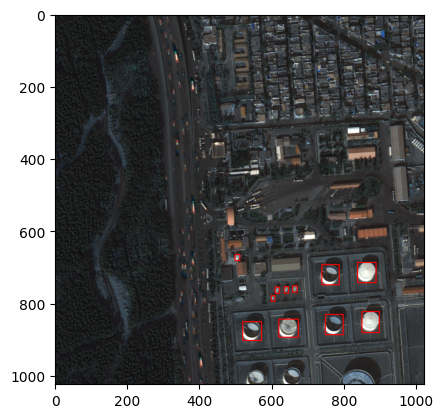

In [19]:
for e, i in enumerate(os.listdir(trainDataLabelPath)):
    if e < 10:
        filename = i.split(".")[0]+".png"
        img = cv2.imread(os.path.join(trainDataImgPath, filename))
        df = pd.read_csv(os.path.join(trainDataLabelPath,i))
        for row in df.iterrows():
            x1 = int(row[1][0])
            y1 = int(row[1][1])
            x3 = int(row[1][4])
            y3 = int(row[1][5])
            cv2.rectangle(img,(x1,y1),(x3,y3),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        plt.show()
        break

In [20]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [21]:
train_images=[]
train_labels=[]

In [22]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [23]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [24]:
for e,i in enumerate(os.listdir(trainDataLabelPath)):
    try:
        filename = i.split(".")[0]+".png"
        print(e,filename)
        image = cv2.imread(os.path.join(trainDataImgPath,filename))
        df = pd.read_csv(os.path.join(trainDataLabelPath,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0])
            y1 = int(row[1][1])
            x3 = int(row[1][4])
            y3 = int(row[1][5])
            gtvalues.append({"x1":x1,"x2":x3,"y1":y1,"y2":y3})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 OBJ03902_PS3_K3A_NIA0164.png
1 OBJ05300_PS3_K3A_NIA0344.png
2 OBJ04912_PS3_K3A_NIA0322.png
3 OBJ04492_PS3_K3A_NIA0296.png
4 OBJ03970_PS3_K3A_NIA0166.png
5 OBJ03728_PS3_K3A_NIA0156.png

error in OBJ03728_PS3_K3A_NIA0156.png
6 OBJ04514_PS3_K3A_NIA0298.png
7 OBJ02634_PS3_K3_NIA0126.png
8 OBJ04870_PS3_K3A_NIA0318.png
9 OBJ03514_PS3_K3A_NIA0146.png
10 OBJ03906_PS3_K3A_NIA0165.png
11 OBJ05506_PS3_K3A_NIA0166.png
inside
12 OBJ05428_PS3_K3A_NIA0350.png
13 OBJ05069_PS3_K3A_NIA0330.png
14 OBJ03859_PS3_K3A_NIA0162.png
inside
15 OBJ03166_PS3_K3_NIA0128.png
16 OBJ03550_PS3_K3A_NIA0149.png
17 OBJ05050_PS3_K3A_NIA0329.png
18 OBJ05284_PS3_K3A_NIA0342.png
19 OBJ05003_PS3_K3A_NIA0328.png
20 OBJ04750_PS3_K3A_NIA0314.png
21 OBJ05532_PS3_K3A_NIA0353.png

error in OBJ05532_PS3_K3A_NIA0353.png
22 OBJ03810_PS3_K3A_NIA0159.png
23 OBJ03785_PS3_K3A_NIA0158.png
24 OBJ04007_PS3_K3A_NIA0167.png
25 OBJ05252_PS3_K3A_NIA0341.png
26 OBJ03720_PS3_K3A_NIA0156.png
27 OBJ04673_PS3_K3A_NIA0312.png
28 OBJ03652_PS3_K3A_NIA0

In [25]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [26]:
X_new.shape

(2519, 224, 224, 3)

In [27]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [28]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [29]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [30]:
X= vggmodel.layers[-2].output

In [31]:
predictions = Dense(2, activation="softmax")(X)

In [32]:
model_final = Model(vggmodel.input, predictions)

In [33]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [34]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [36]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [37]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [38]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [39]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2267, 224, 224, 3) (252, 224, 224, 3) (2267, 2) (252, 2)


In [40]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [42]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [43]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

<ipython-input-43-38b979feae57>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.7625
Epoch 1: val_loss improved from inf to 0.30268, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 30s 2s/step - loss: 1.1331 - accuracy: 0.7625 - val_loss: 0.3027 - val_accuracy: 0.9219
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.9062
Epoch 2: val_loss did not improve from 0.30268
10/10 [==============================] - 6s 585ms/step - loss: 0.3244 - accuracy: 0.9062 - val_loss: 0.3631 - val_accuracy: 0.8906
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9079
Epoch 3: val_loss improved from 0.30268 to 0.22142, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 18s 2s/step - loss: 0.2516 - accuracy: 0.9079 - val_loss: 0.2214 - val_accuracy: 0.8906
Epoch 4/1000
10/10 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9375
Epoch 4:

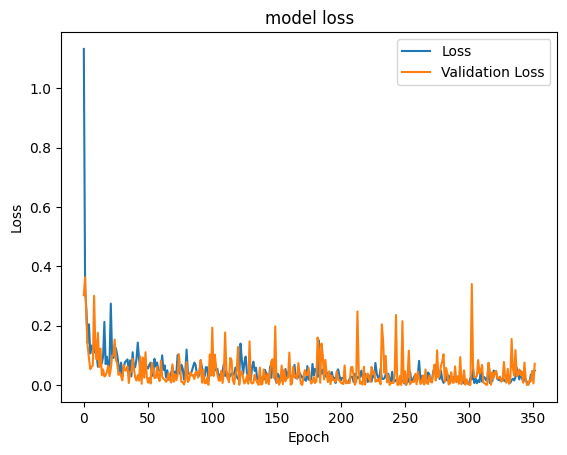

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 0s 23ms/step
not plane


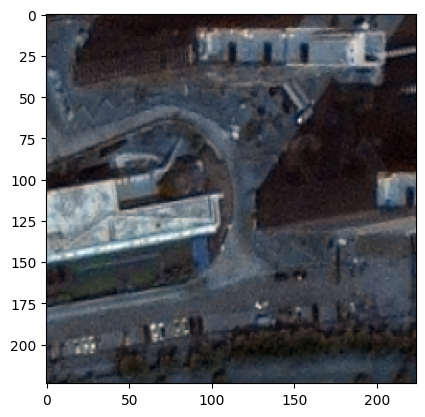

In [69]:
im = X_test[251]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

0 OBJ03913_PS3_K3A_NIA0165.png


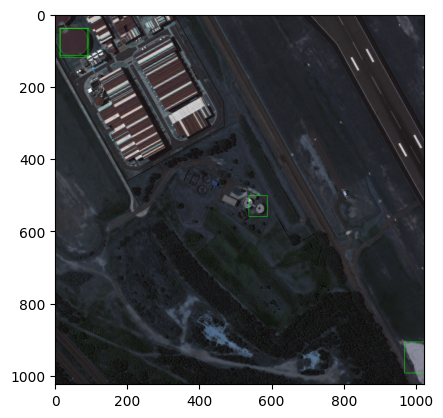

1 OBJ04926_PS3_K3A_NIA0172.png


KeyboardInterrupt: ignored

In [93]:
z=0
path = "/content/drive/MyDrive/oiltank_dataset/oiltank_dataset/valid_images"

for e,i in enumerate(os.listdir(path)):
      z += 1
      filename = i.split(".")[0]+".png"
      print(e,filename)
      img = cv2.imread(os.path.join(path,filename))
      ss.setBaseImage(img)
      ss.switchToSelectiveSearchFast()
      ssresults = ss.process()
      imout = img.copy()
      for e,result in enumerate(ssresults):
          if e < 2000:
              x,y,w,h = result
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
              img = np.expand_dims(resized, axis=0)
              out= model_final.predict(img, verbose=0)
              if out[0][0] > 0.65:
                  cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
      plt.figure()
      plt.imshow(imout)
      plt.show()